<a href="https://colab.research.google.com/github/astrodatos/proyecto_jablpipol/blob/master/Constante_de_Hubble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Ahora lo mismo con las supernovas
# Lo subimos de Google Drive

from google.colab import drive
drive.mount('/content/gdrive')
archivo_supernovas = ('/content/gdrive/My Drive/Taller de proyecto/Supernovas.csv')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
!pip install --pre  --quiet astroquery


     |████████████████████████████████| 4.3MB 2.8MB/s 
     |████████████████████████████████| 2.3MB 38.6MB/s 
     |████████████████████████████████| 61kB 19.5MB/s 
     |████████████████████████████████| 102kB 24.9MB/s 


In [0]:
# Importamos lo necesario
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from sklearn.datasets import *
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import LinearRegression
from sklearn import metrics

from mpl_toolkits import mplot3d
from astroquery.sdss import SDSS





In [5]:
# Procedemos a realizar el query para tomar 80.000 galaxias con espectro y fotometría

data = SDSS.query_sql("""SELECT TOP 80000
                      p.psfMag_u, p.psfMag_g , p.psfMag_r, p.psfMag_i, p.psfMag_z, s.z, s.zErr,s.class
                      
                      FROM PhotoObjAll AS p JOIN specObjAll s ON s.bestobjid = p.objid
                      
                      WHERE p.mode = 1 AND s.sciencePrimary = 1 AND p.clean = 1 AND s.class ='GALAXY'
                      
                      """)

# Cambiamos el formato de la tabla obtenida con astroquery a pandas
data_df = data.to_pandas()



/usr/local/lib/python3.6/dist-packages/astroquery/sdss/core.py:865: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  comments='#'))


0.25508581264828467

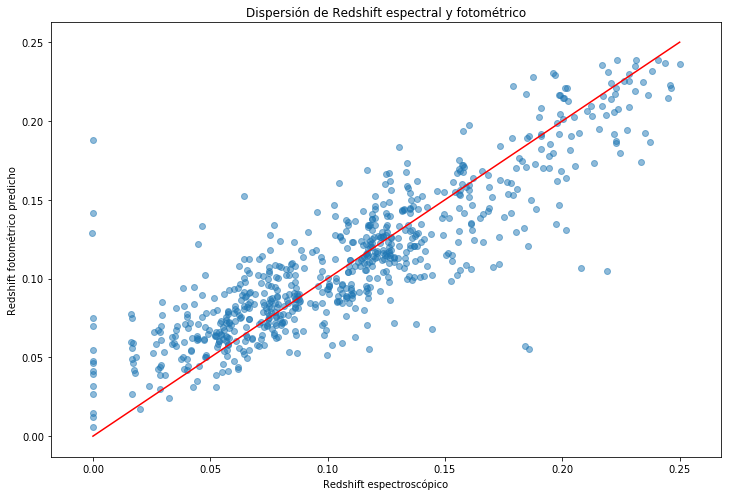

In [6]:
# Analizando redshift y machine learning para redshift pequeño

redshift_pequeño = data_df[data_df["z"]<0.25]


fotometria_p = redshift_pequeño[['psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i', 'psfMag_z']]
train_px = fotometria_p[0:-1]
train_py = redshift_pequeño["z"][0:-1]

KNR_P = KNeighborsRegressor(5)
KNR_P.fit(train_px, train_py)


prueba_z = KNR_P.predict(fotometria_p[30000:])



plt.figure(figsize=(12,8))
plt.scatter(redshift_pequeño['z'][30000:], prueba_z, alpha=0.5)
plt.plot(np.array([0,0.25]), np.array([0,0.25]), color = "red")
plt.title("Dispersión de Redshift espectral y fotométrico")
plt.xlabel("Redshift espectroscópico")
plt.ylabel("Redshift fotométrico predicho")


promedio = np.mean(redshift_pequeño['z'][30000:])
error = np.sqrt(metrics.mean_squared_error(redshift_pequeño['z'][30000:], prueba_z ))
error/promedio

Mean Absolute Error: 0.033944071446039996
Mean Squared Error: 0.0033097533995232295


0.17199710888881392

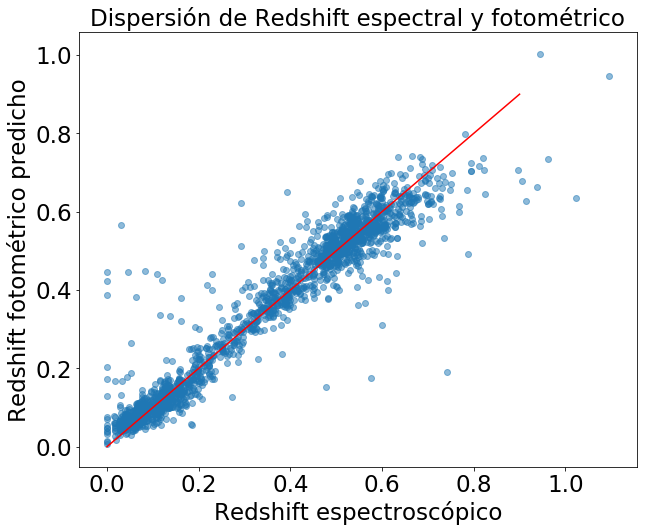

In [7]:
# Machine learning

fotometria = data_df[['psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i', 'psfMag_z']]

train_x = fotometria[:80000]

train_y = data_df['z'][:80000]

KNR = KNeighborsRegressor(5)
KNR.fit(train_x, train_y)


####################################################################

from matplotlib.pyplot import rcParams
matplotlib.rcParams.update({'font.size': 16}) 
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
rcParams.update(params)


predictor_z = KNR.predict(fotometria[78000:])

plt.figure(figsize=(10,8))
plt.scatter(data_df['z'][78000:], predictor_z, alpha=0.5)
plt.plot(np.array([0,0.9]), np.array([0,0.9]), color = "red")
plt.title("Dispersión de Redshift espectral y fotométrico")
plt.xlabel("Redshift espectroscópico")
plt.ylabel("Redshift fotométrico predicho")
####################################################################

print('Mean Absolute Error:', metrics.mean_absolute_error(data_df['z'][78000:], predictor_z))  
print('Mean Squared Error:', metrics.mean_squared_error(data_df['z'][78000:], predictor_z ))
error = np.sqrt(metrics.mean_squared_error(data_df['z'][78000:], predictor_z ))

promedio = np.mean(data_df['z'][78000:])

plt.savefig("Gráfico_de_dispersión_Redshift_completo.png")

error/promedio

Text(0.5, 1.0, 'Puntaje en función del número de vecinos')

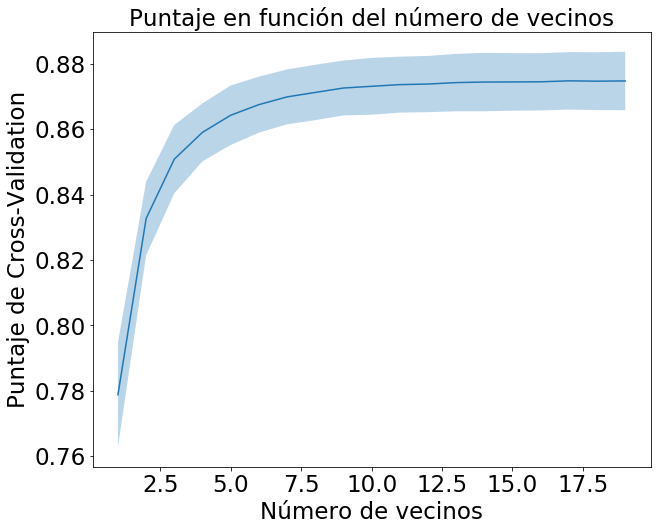

In [8]:

#Mejor numero de neighbours
from sklearn.model_selection import cross_val_score
neighbors = np.arange(1,20,1)
scores = np.zeros(np.shape(neighbors))
stds = np.zeros(np.shape(neighbors))


for s, n in enumerate(neighbors):
  clf = KNeighborsRegressor(n_neighbors=n)
  cv_scores = cross_val_score(clf, train_x, train_y, cv=10, scoring=None)
  scores[s] = cv_scores.mean()
  stds[s] = cv_scores.std()

  
matplotlib.rcParams.update({'font.size': 16}) 
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
rcParams.update(params)

plt.figure(figsize=(10,8))
plt.fill_between(neighbors, scores-stds, scores+stds, alpha=0.3)
plt.plot(neighbors, scores)
plt.xlabel('Número de vecinos')
plt.ylabel('Puntaje de Cross-Validation')
plt.title('Puntaje en función del número de vecinos')

In [9]:

#Cross validation

# Creamos un nuevo clasificador para hacer las pruebas de cross-validation
cv_knn_clf =  KNeighborsRegressor(n_neighbors=35)

# Calculamos el puntaje tomando [cv] subconjuntos del conjunto de entrenamiento
# Usamos el accuracy como métrica
scores = cross_val_score(cv_knn_clf, train_x, train_y, cv=10, scoring=None)

print('Cross validation promedio: ', format(scores.mean(), '.3f'))
print('Cross validation std:      ', format(scores.std(), '.3f'))

Cross validation promedio:  0.874
Cross validation std:       0.009


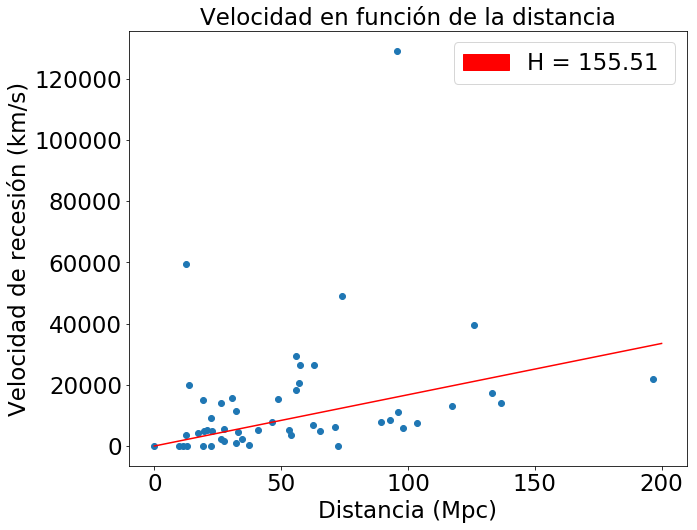

In [10]:
# Subimos el archivo con base de datos de galaxias y supernovas 

base_de_datos = ('/content/gdrive/My Drive/Taller de proyecto/Base de datos completa1.csv')

datos_g_s = pd.read_csv(base_de_datos, sep=',', index_col=0)

distancia = datos_g_s["Distancia (en Mpc)"].values.tolist()

# Transformación string a float

fotometria_gh = datos_g_s[['psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i', 'psfMag_z']]

redshift_fotométrico = KNR.predict(fotometria_gh)



c = 299792.458 
# Con redshift completo
numerador = (np.square(redshift_fotométrico+1)-1)
denominador = (np.square(redshift_fotométrico+1)+1)

velocidad_recesion = c*np.divide(numerador,denominador)


# Agregar 0,0

distancia_1 = np.append(distancia,[0])
vel_1 = np.append(velocidad_recesion,[0])


plt.figure(figsize=(10,8))
plt.plot(distancia_1, vel_1, "o")

from numpy.polynomial import polynomial as P

constantes = P.polyfit(distancia_1, vel_1, 1)

pendiente = 167.54

equis = np.arange(0,201)
ye = equis*pendiente

plt.plot(equis,ye, color = "red")
plt.xlabel("Distancia (Mpc)")
plt.ylabel("Velocidad de recesión (km/s)")
plt.title("Velocidad en función de la distancia")

red_patch = mpatches.Patch(color='red', label='H = 155.51 ')

plt.legend(handles=[red_patch])


In [0]:
diccionario = {"Distancia": distancia , "Velocidad": velocidad_recesion}

pandita = pd.DataFrame(data = diccionario)

malos_malosos = pandita[pandita["Velocidad"] == 0].index.values.tolist()

pandita = pandita.drop(malos_malosos, axis = 0)

malos_2 = pandita[pandita["Velocidad"]> 25000].index.values.tolist()

pandita_is_back = pandita.drop(malos_2, axis = 0)

filtrado1 = pandita_is_back[pandita_is_back["Velocidad"]>12000]
malos3 = filtrado1[filtrado1["Distancia"] < 80].index.values.tolist()

pandita_contrataca = pandita_is_back.drop(malos3, axis=0)


dist = pandita_contrataca["Distancia"].values.tolist()
vel = pandita_contrataca["Velocidad"].values.tolist()

dist_weno = np.append(dist,[0])
vel_weno = np.append(vel,[0])




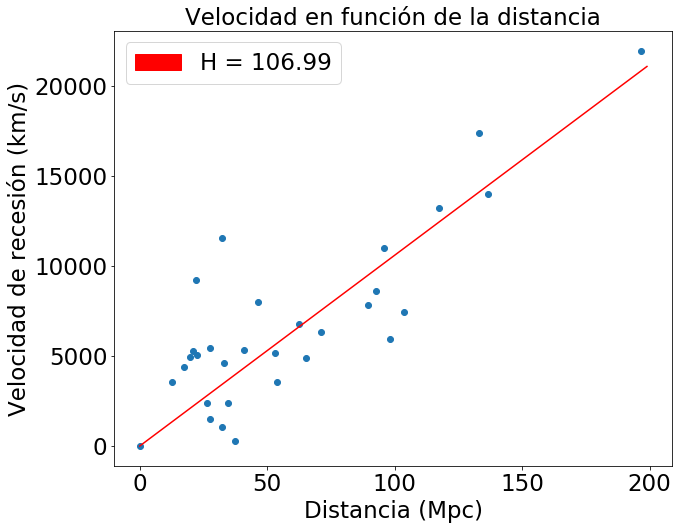

In [12]:
from scipy.optimize import curve_fit

# Fitting lineal

def funcion(datos,m,n):
  return datos*m+n

constantes_fitting1 = curve_fit(funcion, dist, vel,bounds=(0,[200,1] ))

constantes_fitting2 = curve_fit(funcion, distancia_1, vel_1, bounds=(0,[200,1]))


# Gráficos

plt.figure(figsize=(10,8))
plt.plot(dist_weno,vel_weno, "o")


pendiente = constantes_fitting1[0][0]

equis = np.arange(0,200)
ye = equis*(pendiente) 


plt.plot(equis,ye, color = "red")
plt.xlabel("Distancia (Mpc)")
plt.ylabel("Velocidad de recesión (km/s)")
plt.title("Velocidad en función de la distancia")


red_patch = mpatches.Patch(color='red', label='H = 106.99')

plt.legend(handles=[red_patch])

error_H = np.sqrt(constantes_fitting2[1][0][0])
